# Build a model from the unaugmented and unbalanced data

<p>In this notebook, the unaugmented and unbalanced data is used to build models using four different classifiers, with and without class weight balancing, and with and without synthetic minority oversampling technique (SMOTE):</p>
<ul>
    <li>MLP Classifier</li>
    <li>Random Forest</li>
    <li>Linear SVC</li>
    <li>Logistic Regression</li>
</ul>

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import json
import pickle
import spacy
from spacy.matcher import DependencyMatcher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_lg')
matcher = DependencyMatcher(nlp.vocab)

In [3]:
# Open the pattern JSON file
with open("../data/patterns.json", "r") as file:
    patterns_dict = json.load(file)

# Add the patterns to the matcher
for pattern_name, pattern_list in patterns_dict.items():
    matcher.add(f'{pattern_name}', [pattern_list])

In [4]:
pelic = pd.read_csv('../data/PELIC_cleaned.csv').drop(['Unnamed: 0'],axis=1)
asag = pd.read_csv('../data/ASAG_cleaned.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
pelic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31099 entries, 0 to 31098
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   answer_id         31099 non-null  int64  
 1   question_id       31099 non-null  int64  
 2   anon_id           31099 non-null  object 
 3   course_id         31099 non-null  int64  
 4   created_date      31099 non-null  object 
 5   text_len          31099 non-null  int64  
 6   answer            31099 non-null  object 
 7   tokens            31099 non-null  object 
 8   tok_lem_POS       31099 non-null  object 
 9   question_type_id  31099 non-null  float64
 10  question          31099 non-null  object 
 11  allow_text        31099 non-null  float64
 12  gender            31099 non-null  object 
 13  L1                31099 non-null  object 
 14  class_id          31099 non-null  object 
 15  level             31099 non-null  int64  
 16  question_type     31099 non-null  object

In [6]:
asag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file_name        268 non-null    object 
 1   age_participant  268 non-null    int64  
 2   sex_participant  268 non-null    object 
 3   education        268 non-null    object 
 4   L1               268 non-null    object 
 5   sex_examiner1    268 non-null    object 
 6   sex_examiner2    268 non-null    object 
 7   sex_examiner3    268 non-null    object 
 8   setting          268 non-null    object 
 9   question         268 non-null    object 
 10  word_limit       268 non-null    object 
 11  level_course     268 non-null    int64  
 12  answer           268 non-null    object 
 13  grade_examiner1  268 non-null    int64  
 14  grade_examiner2  267 non-null    float64
 15  grade_examiner3  268 non-null    int64  
 16  level            268 non-null    int64  
 17  question_type   

In [7]:
# Merge the pelic and asag dataframes
columns_to_merge = ['level','answer']
pelic_trimmed = pelic[columns_to_merge]
asag_trimmed = asag[columns_to_merge]
df = pd.concat([pelic_trimmed,asag_trimmed]).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31367 entries, 0 to 31366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   level   31367 non-null  int64 
 1   answer  31367 non-null  object
dtypes: int64(1), object(1)
memory usage: 490.2+ KB


In [9]:
df.level.value_counts()

level
4    12230
5    10122
3     8090
2      903
1       17
6        5
Name: count, dtype: int64

In [10]:
df = df[(df['level'] != 1) & (df['level'] != 6)]
df.level.value_counts()

level
4    12230
5    10122
3     8090
2      903
Name: count, dtype: int64

In [13]:
# Define functions to extract features
def count_patterns(text, matcher):
    """Count the number of pattern matches in the text."""
    # convert text to nlp doc
    doc = nlp(text)
    # store the matches
    matches = matcher(doc)
    # count the matches
    # count matches in respective columns
    counts = {pattern_name: 0 for pattern_name in patterns_dict.keys()}
    for match_id, token_ids in matches:
        pattern_name = matcher.vocab.strings[match_id]
        counts[pattern_name] += 1
    return counts

def find_patterns(df):
    df = df.copy()
    pattern_names = list(patterns_dict.keys())
    
    # Initialize columns for pattern counts as floats
    for pattern_name in pattern_names:
        df[pattern_name] = 0.0
    
    df['num_sentences'] = 0
    df['avg_sentence_len'] = 0.0
    df['doc_vector'] = None
    
    for index, row in df.iterrows():
        answer_text = row['answer']
        doc = nlp(answer_text)
        total_tokens = 0
        num_sentences = 0

        # First, count the sentences and calculate average sentence length
        for sentence in doc.sents:
            num_tokens = len(sentence)
            total_tokens += num_tokens
            num_sentences += 1

        avg_sentence_len = total_tokens / num_sentences if num_sentences > 0 else 0
        df.loc[index, 'num_sentences'] = num_sentences
        df.loc[index, 'avg_sentence_len'] = avg_sentence_len

        # Count patterns in the original text
        pattern_counts = count_patterns(answer_text, matcher)
        for pattern_name, count in pattern_counts.items():
            df.at[index, pattern_name] = count

        # Vectorize the text
        df.at[index, 'doc_vector'] = doc.vector
    
    return df

In [14]:
df = find_patterns(df)
df.head()

,level,answer,present_simple_active,present_simple_active_aux,present_simple_active_modal,present_simple_passive,present_simple_passive_modal,present_continuous_active,present_continuous_active_modal,present_continuous_passive,...,past_perfect_continuous_active,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp,num_sentences,avg_sentence_len,doc_vector
0,4,I met my friend Nife while I was studying in a...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,16.083333,"[-1.9136966, 0.803644, -2.3635178, -0.64024603..."
1,4,"Ten years ago, I met a women on the train betw...",2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,14.181818,"[-2.1504033, 1.1586652, -2.2990868, -1.081227,..."
2,4,In my country we usually don't use tea bags. F...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,14.400000,"[-0.9355672, 1.0261846, -3.1468487, 0.6975146,..."
3,4,I organized the instructions by time.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.000000,"[-3.1716976, -1.727, -1.8290098, -1.0553071, 3..."
4,4,"First, prepare a port, loose tea, and cup.\nSe...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6,13.000000,"[-1.8519892, 0.5633237, -2.0954006, 1.0368975,..."


In [15]:
# Save the DataFrame to a pickle file because it takes long to run, and a csv changes the vectors to strings
with open('../data/PELIC_ASAG_cleaned_matched_vectors.pkl', 'wb') as file:
    pickle.dump(df, file)

In [45]:
# Load the DataFrame from a pickle file
with open('../data/PELIC_ASAG_cleaned_matched_vectors.pkl', 'rb') as file:
    df = pickle.load(file)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31345 entries, 0 to 31366
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   level                                     31345 non-null  int64  
 1   answer                                    31345 non-null  object 
 2   present_simple_active                     31345 non-null  float64
 3   present_simple_active_aux                 31345 non-null  float64
 4   present_simple_active_modal               31345 non-null  float64
 5   present_simple_passive                    31345 non-null  float64
 6   present_simple_passive_modal              31345 non-null  float64
 7   present_continuous_active                 31345 non-null  float64
 8   present_continuous_active_modal           31345 non-null  float64
 9   present_continuous_passive                31345 non-null  float64
 10  present_continuous_passive_modal       

In [47]:
df.head()

,level,answer,present_simple_active,present_simple_active_aux,present_simple_active_modal,present_simple_passive,present_simple_passive_modal,present_continuous_active,present_continuous_active_modal,present_continuous_passive,...,past_perfect_continuous_active,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp,num_sentences,avg_sentence_len,doc_vector
0,4,I met my friend Nife while I was studying in a...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,16.083333,"[-1.9136966, 0.803644, -2.3635178, -0.64024603..."
1,4,"Ten years ago, I met a women on the train betw...",2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,14.181818,"[-2.1504033, 1.1586652, -2.2990868, -1.081227,..."
2,4,In my country we usually don't use tea bags. F...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,14.400000,"[-0.9355672, 1.0261846, -3.1468487, 0.6975146,..."
3,4,I organized the instructions by time.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.000000,"[-3.1716976, -1.727, -1.8290098, -1.0553071, 3..."
4,4,"First, prepare a port, loose tea, and cup.\nSe...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6,13.000000,"[-1.8519892, 0.5633237, -2.0954006, 1.0368975,..."


In [48]:
# Look at the columns and select which ones to use in X
df.columns

Index(['level', 'answer', 'present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would', 'gerund_subject', 'gerund_pcomp', 'gerund_xcomp',
       'num_sent

In [49]:
# Define a df for the average sentence length
df_avg_sentence_len = df['avg_sentence_len']
df_avg_sentence_len = df_avg_sentence_len.reset_index(drop=True)

In [51]:
# Create a df of verb tense counts and square the counts so that they're more detectable in the model
verbs_df = df[['present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would', 'gerund_subject', 'gerund_pcomp', 'gerund_xcomp']] **2
verbs_df = verbs_df.reset_index(drop=True)
verbs_df.head()

,present_simple_active,present_simple_active_aux,present_simple_active_modal,present_simple_passive,present_simple_passive_modal,present_continuous_active,present_continuous_active_modal,present_continuous_passive,present_continuous_passive_modal,present_perfect_active,...,past_continuous_passive,past_perfect_active,past_perfect_passive,past_perfect_continuous_active,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [52]:
# Put each element from the doc vector into a column in a new df
vectors_df = pd.DataFrame(df['doc_vector'].values.tolist(), columns=[f'doc_vector_{i}' for i in range(300)])
# Reset the index to ensure clean concatenation
vectors_df = vectors_df.reset_index(drop=True)
vectors_df.head()

,doc_vector_0,doc_vector_1,doc_vector_2,doc_vector_3,doc_vector_4,doc_vector_5,doc_vector_6,doc_vector_7,doc_vector_8,doc_vector_9,...,doc_vector_290,doc_vector_291,doc_vector_292,doc_vector_293,doc_vector_294,doc_vector_295,doc_vector_296,doc_vector_297,doc_vector_298,doc_vector_299
0,-1.913697,0.803644,-2.363518,-0.640246,2.820532,0.672483,0.360771,4.989578,-0.423399,1.075111,...,1.614889,-0.980653,-0.459001,-0.965387,-1.622698,1.769468,0.533631,-0.297157,-3.228177,0.486890
1,-2.150403,1.158665,-2.299087,-1.081227,2.992299,-0.129341,0.340588,5.281645,-0.115680,1.294657,...,1.425660,-0.351378,-0.155626,-0.960107,-2.044958,1.044529,1.299488,0.364705,-3.728453,0.989865
2,-0.935567,1.026185,-3.146849,0.697515,2.857459,-0.607013,-0.732699,3.621341,-1.908440,1.615052,...,0.785678,-0.217158,1.714401,-0.462082,-3.297910,0.815477,0.560488,-0.410408,-1.795619,0.789071
3,-3.171698,-1.727000,-1.829010,-1.055307,3.236671,-0.392754,0.530900,2.648694,-1.016326,0.915913,...,2.119361,0.533999,-0.818269,1.464990,-2.591085,1.707127,1.446669,-3.392868,-1.903727,2.137342
4,-1.851989,0.563324,-2.095401,1.036898,3.288558,-0.535378,-0.495327,4.023538,0.011050,0.538570,...,-0.145617,-0.722805,0.933672,-1.090237,-3.204577,0.742320,0.938244,-0.570475,-1.129136,0.525613


In [53]:
# Concatenate the dataframes
df_concat = pd.concat([df_avg_sentence_len, verbs_df, vectors_df], axis=1)
# Check for nulls after the concatentation
print(f"Null values in df_concat: {df_concat.isnull().sum().sum()}")
print(f"Shape of df_concat: {df_concat.shape}")

Null values in df_concat: 0
Shape of df_concat: (31345, 332)


## Split and Scale

In [54]:
X = df_concat
y = df['level']

In [55]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [56]:
# Normalize the data
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

## Logistic Regression

In [77]:
# Initialize and train the classifier
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_normalized)

Overall Accuracy: 0.5123133852239378
              precision    recall  f1-score   support

           2       0.18      0.73      0.28       226
           3       0.55      0.42      0.48      2022
           4       0.57      0.55      0.56      3058
           5       0.56      0.52      0.54      2531

    accuracy                           0.51      7837
   macro avg       0.46      0.56      0.46      7837
weighted avg       0.55      0.51      0.52      7837

Confusion Matrix:
[[ 166   35   13   12]
 [ 336  853  495  338]
 [ 286  395 1671  706]
 [ 152  280  774 1325]]


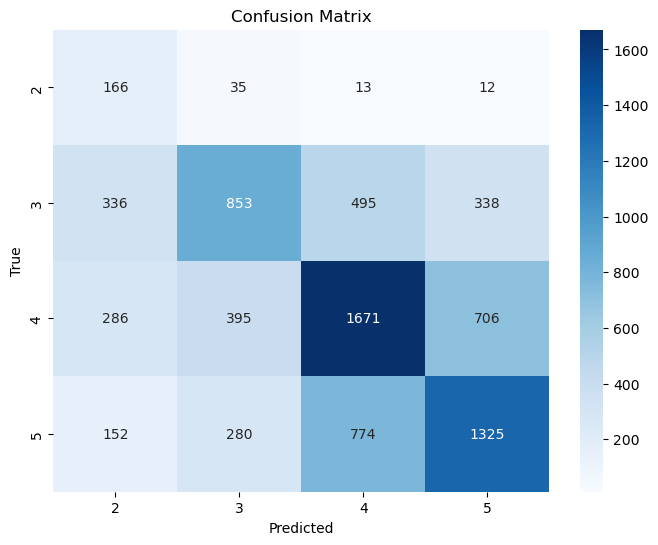

In [59]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Linear SVC

In [62]:
# Initialize and train the classifier
svc = LinearSVC(class_weight='balanced', dual=True)
svc.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = svc.predict(X_test_normalized)

Overall Accuracy: 0.5565905320913614
              precision    recall  f1-score   support

           2       0.26      0.65      0.37       226
           3       0.58      0.48      0.53      2022
           4       0.58      0.63      0.60      3058
           5       0.58      0.52      0.55      2531

    accuracy                           0.56      7837
   macro avg       0.50      0.57      0.51      7837
weighted avg       0.57      0.56      0.56      7837

Confusion Matrix:
[[ 146   53   18    9]
 [ 167  972  557  326]
 [ 149  369 1920  620]
 [  93  282  832 1324]]


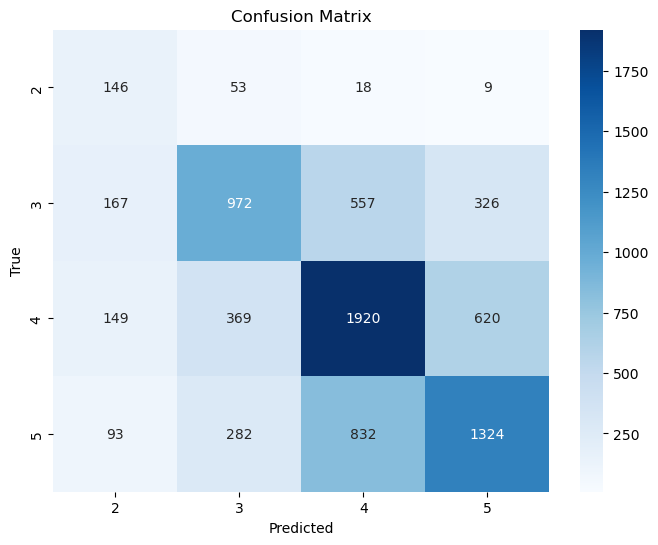

In [63]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc.classes_, yticklabels=svc.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Random Forest

In [66]:
# Initialize and train the classifier
rf = RandomForestClassifier(class_weight='balanced', bootstrap=True)
rf.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_normalized)

Overall Accuracy: 0.649355620773255
              precision    recall  f1-score   support

           2       0.84      0.16      0.27       226
           3       0.65      0.59      0.62      2022
           4       0.63      0.73      0.68      3058
           5       0.67      0.64      0.66      2531

    accuracy                           0.65      7837
   macro avg       0.70      0.53      0.56      7837
weighted avg       0.66      0.65      0.64      7837

Confusion Matrix:
[[  37   90   75   24]
 [   4 1196  551  271]
 [   2  338 2225  493]
 [   1  226  673 1631]]


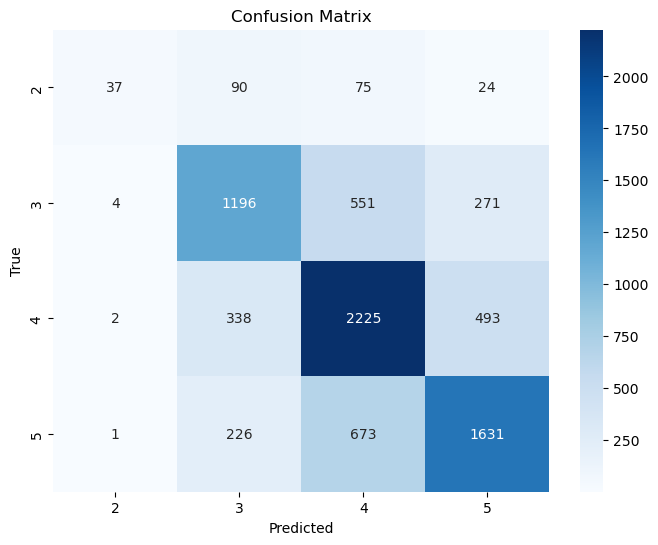

In [67]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Neural Network Classifier

In [72]:
# Initialize and train the classifier
mlp = MLPClassifier(max_iter=2000)
mlp.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_normalized)

Overall Accuracy: 0.6913359703968355
              precision    recall  f1-score   support

           2       0.50      0.50      0.50       226
           3       0.72      0.62      0.67      2022
           4       0.70      0.72      0.71      3058
           5       0.68      0.73      0.70      2531

    accuracy                           0.69      7837
   macro avg       0.65      0.64      0.64      7837
weighted avg       0.69      0.69      0.69      7837

Confusion Matrix:
[[ 112   49   46   19]
 [  58 1263  403  298]
 [  35  260 2200  563]
 [  21  179  488 1843]]


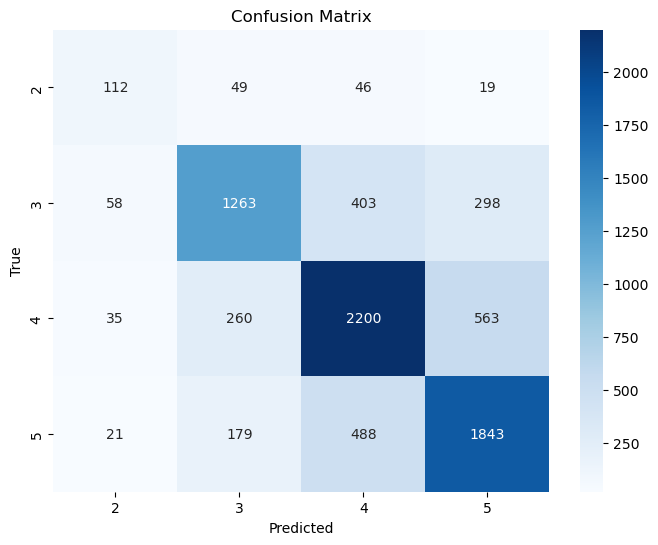

In [73]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Apply SMOTE

In [75]:
# Apply SMOTE to the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_normalized, y_train)

### Logistic Regression

In [84]:
# Initialize and train the classifier
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = log_reg_smote.predict(X_test_normalized)

Overall Accuracy: 0.5245629705244353
              precision    recall  f1-score   support

           2       0.19      0.75      0.30       226
           3       0.56      0.44      0.49      2022
           4       0.58      0.57      0.57      3058
           5       0.57      0.52      0.55      2531

    accuracy                           0.52      7837
   macro avg       0.47      0.57      0.48      7837
weighted avg       0.56      0.52      0.53      7837

Confusion Matrix:
[[ 169   34   14    9]
 [ 319  887  486  330]
 [ 276  383 1729  670]
 [ 148  292  765 1326]]


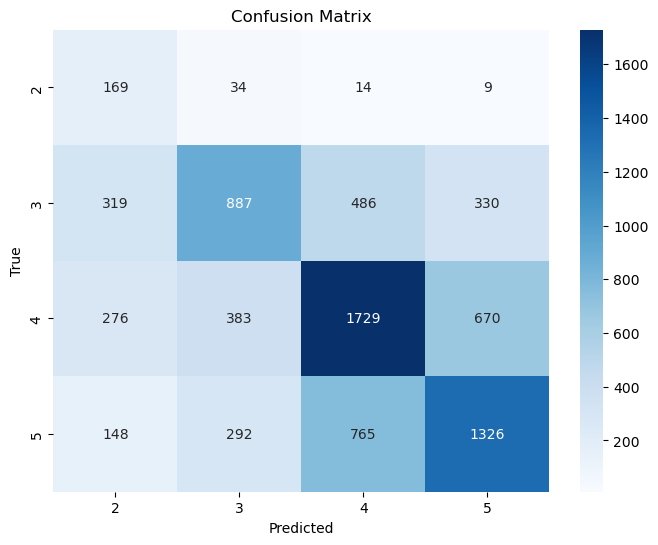

In [85]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg_smote.classes_, yticklabels=log_reg_smote.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Linear SVC

In [82]:
# Initialize and train the classifier
svc_smote = LinearSVC(dual=True)
svc_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = svc_smote.predict(X_test_normalized)

Overall Accuracy: 0.540257751690698
              precision    recall  f1-score   support

           2       0.20      0.79      0.32       226
           3       0.58      0.45      0.51      2022
           4       0.60      0.58      0.59      3058
           5       0.57      0.54      0.55      2531

    accuracy                           0.54      7837
   macro avg       0.49      0.59      0.49      7837
weighted avg       0.57      0.54      0.55      7837

Confusion Matrix:
[[ 178   32   10    6]
 [ 315  920  444  343]
 [ 229  376 1768  685]
 [ 152  271  740 1368]]


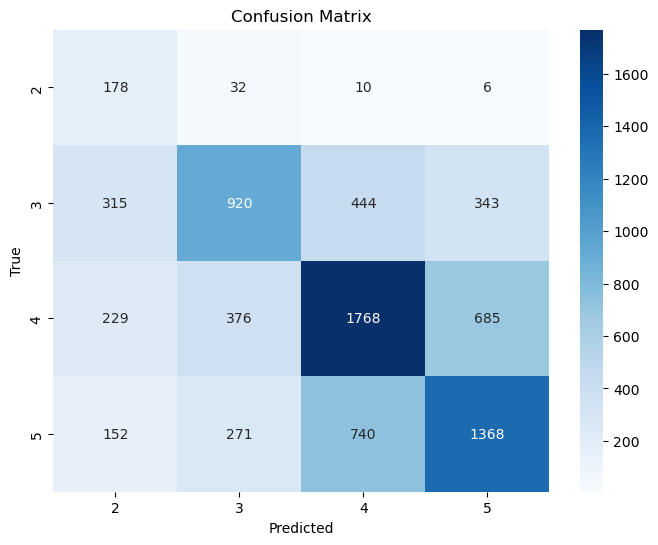

In [83]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc_smote.classes_, yticklabels=svc_smote.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

In [87]:
# Initialize and train the classifier
rf_smote = RandomForestClassifier()
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = rf_smote.predict(X_test_normalized)

Overall Accuracy: 0.6594360086767896
              precision    recall  f1-score   support

           2       0.52      0.48      0.50       226
           3       0.60      0.70      0.65      2022
           4       0.71      0.64      0.67      3058
           5       0.67      0.67      0.67      2531

    accuracy                           0.66      7837
   macro avg       0.63      0.62      0.62      7837
weighted avg       0.66      0.66      0.66      7837

Confusion Matrix:
[[ 108   88   20   10]
 [  41 1415  314  252]
 [  44  497 1944  573]
 [  13  345  472 1701]]


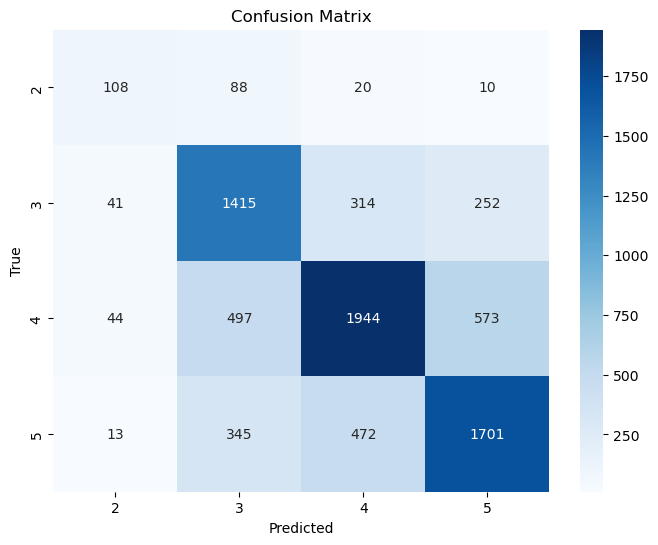

In [88]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_smote.classes_, yticklabels=rf_smote.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Neural Network Classifier

In [89]:
# Initialize and train the classifier
mlp_smote = MLPClassifier(max_iter=2000)
mlp_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = mlp_smote.predict(X_test_normalized)

Overall Accuracy: 0.6929947684062779
              precision    recall  f1-score   support

           2       0.51      0.50      0.50       226
           3       0.67      0.71      0.69      2022
           4       0.71      0.70      0.70      3058
           5       0.71      0.69      0.70      2531

    accuracy                           0.69      7837
   macro avg       0.65      0.65      0.65      7837
weighted avg       0.69      0.69      0.69      7837

Confusion Matrix:
[[ 113   60   33   20]
 [  48 1442  328  204]
 [  40  388 2132  498]
 [  22  248  517 1744]]


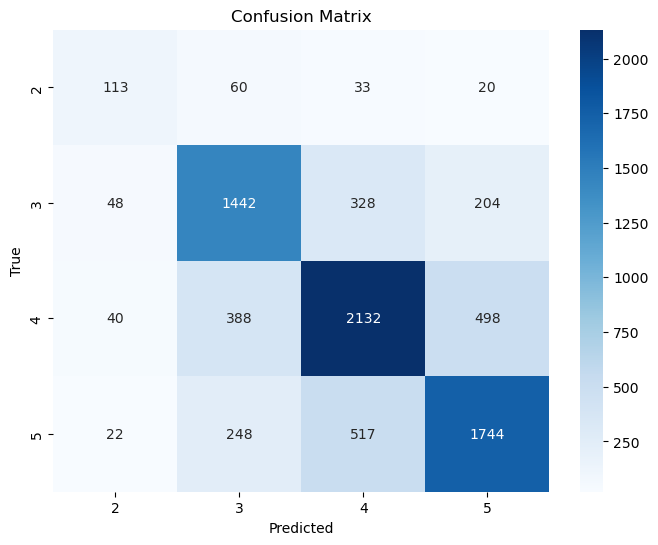

In [90]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_smote.classes_, yticklabels=rf_smote.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()